## Data from sediment 
This notebook will focus on microbiome data collected from sediment of watertanks holding fish with different probiotic supplementation added

### Import and preprocessing

In [5]:
#libraries import
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
# for tensorboard logs
import datetime
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.preprocessing import normalize
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split, KFold
from functions import *
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import EarlyStopping

np.random.seed(111)
tf.random.set_seed(111)


In [6]:

kf = KFold(n_splits=5, shuffle=True, random_state=111)


In [7]:
df = pd.read_csv('https://raw.githubusercontent.com/paq88/Fish_neural_network_classifier/refs/heads/main/sed_based/Data/sed_bacteria_merged.csv')
predictors = df.columns[1:]
print(f"number of predictors/bacteria famillies: {len(predictors)}")
      
# adding collumn with timepoints 
classes = np.tile([0, 1], 25)
df.insert(1,"class_timepoint",  classes)

# replacing NaN values with 0
df.fillna(0, inplace=True)

df.head()



number of predictors/bacteria famillies: 227


,pond,class_timepoint,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Sutterellaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Comamonadaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Rhodocyclaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Sphingobacteriales;f__Lentimicrobiaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfobulbaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Chitinophagales;f__Saprospiraceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae,d__Bacteria;p__Actinobacteriota;c__Thermoleophilia;o__Solirubrobacterales;f__67-14,...,d__Bacteria;p__Desulfobacterota;c__Desulfobacteria;o__Desulfobacterales;f__Desulfobacterales,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Sulfurimonadaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfurivibrionaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;__,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Marinilabiliaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rs-E47_termite_group,d__Bacteria;p__Chloroflexi;c__Dehalococcoidia;o__Dehalococcoidales;f__uncultured,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Barnesiellaceae,d__Bacteria;p__Myxococcota;c__Polyangia;o__Blfdi19;f__Blfdi19
0,Sed_S10,0,111.0,128.0,122.0,101.0,84.0,44.0,42.0,52.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Sed_S10,1,18.0,150.0,10.0,129.0,0.0,0.0,30.0,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Sed_S11,0,81.0,21.0,29.0,90.0,0.0,8.0,10.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Sed_S11,1,3.0,13.0,18.0,3.0,0.0,3.0,18.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Sed_S12,0,171.0,67.0,109.0,76.0,23.0,31.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


After the data look and checkup we can see that the dataset cosists of 227 bacteria famillies (columns) which we will treat as features, and 50 rows holding 25 unique values each of those represents one pond, ponds are divided into 5 different experimental setups we will have to decode that. Also there are two values per pond which indicate two points in time. We will perform classification between those two points to see if model is able to notice any significant changes and if it does use feature selection methods to see which bacteria is impacted by time alone regardless of supplementation. Later we will perform classification based on different experimental setups on both timepoints (one timepoint at the time) to see if there are changes between those.  

In [4]:
df.describe()

,class_timepoint,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Sutterellaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Comamonadaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Rhodocyclaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Sphingobacteriales;f__Lentimicrobiaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfobulbaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Chitinophagales;f__Saprospiraceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae,d__Bacteria;p__Actinobacteriota;c__Thermoleophilia;o__Solirubrobacterales;f__67-14,d__Bacteria;p__Cyanobacteria;c__Cyanobacteriia;o__Cyanobacteriales;f__Phormidiaceae,...,d__Bacteria;p__Desulfobacterota;c__Desulfobacteria;o__Desulfobacterales;f__Desulfobacterales,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Sulfurimonadaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfurivibrionaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;__,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Marinilabiliaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rs-E47_termite_group,d__Bacteria;p__Chloroflexi;c__Dehalococcoidia;o__Dehalococcoidales;f__uncultured,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Barnesiellaceae,d__Bacteria;p__Myxococcota;c__Polyangia;o__Blfdi19;f__Blfdi19
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,...,50.000000,50.000000,50.000000,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.500000,87.880000,88.440000,238.540000,60.020000,13.140000,14.420000,17.660000,7.420000,103.480000,...,0.440000,0.720000,0.460000,0.30000,0.900000,0.260000,0.240000,0.220000,0.220000,0.200000
std,0.505076,72.437909,65.694767,359.278484,40.221068,21.783733,21.364753,24.860927,11.510581,127.867636,...,2.214608,4.549232,3.252691,2.12132,4.704535,1.838478,1.697056,1.555635,1.555635,1.414214
min,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,32.000000,34.500000,24.000000,33.250000,0.000000,0.000000,0.000000,0.000000,3.250000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.500000,82.000000,73.500000,88.500000,56.500000,4.000000,2.000000,6.000000,1.500000,51.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,126.250000,121.000000,297.000000,80.000000,19.500000,22.000000,28.000000,10.000000,196.750000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,368.000000,256.000000,1898.000000,170.000000,103.000000,86.000000,113.000000,52.000000,463.000000,...,13.000000,32.000000,23.000000,15.00000,30.000000,13.000000,12.000000,11.000000,11.000000,10.000000


In [5]:
# for normalisation we will use starndard min-max normalisation
df_norm = df.copy()
df_norm[predictors] = normalize(df[predictors], norm='max', axis=0, copy=True, return_norm=False)
df_norm.describe()

,class_timepoint,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Sutterellaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Comamonadaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Rhodocyclaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Sphingobacteriales;f__Lentimicrobiaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfobulbaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Chitinophagales;f__Saprospiraceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae,d__Bacteria;p__Actinobacteriota;c__Thermoleophilia;o__Solirubrobacterales;f__67-14,d__Bacteria;p__Cyanobacteria;c__Cyanobacteriia;o__Cyanobacteriales;f__Phormidiaceae,...,d__Bacteria;p__Desulfobacterota;c__Desulfobacteria;o__Desulfobacterales;f__Desulfobacterales,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Sulfurimonadaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfurivibrionaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;__,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Marinilabiliaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rs-E47_termite_group,d__Bacteria;p__Chloroflexi;c__Dehalococcoidia;o__Dehalococcoidales;f__uncultured,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Barnesiellaceae,d__Bacteria;p__Myxococcota;c__Polyangia;o__Blfdi19;f__Blfdi19
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,...,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.500000,0.238804,0.345469,0.125680,0.353059,0.127573,0.167674,0.156283,0.142692,0.223499,...,0.033846,0.022500,0.020000,0.020000,0.030000,0.020000,0.020000,0.020000,0.020000,0.020000
std,0.505076,0.196842,0.256620,0.189293,0.236595,0.211493,0.248427,0.220008,0.221357,0.276172,...,0.170354,0.142163,0.141421,0.141421,0.156818,0.141421,0.141421,0.141421,0.141421,0.141421
min,0.000000,0.000000,0.011719,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.086957,0.134766,0.012645,0.195588,0.000000,0.000000,0.000000,0.000000,0.007019,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.500000,0.222826,0.287109,0.046628,0.332353,0.038835,0.023256,0.053097,0.028846,0.110151,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.343071,0.472656,0.156481,0.470588,0.189320,0.255814,0.247788,0.192308,0.424946,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
codes = {0 : [8,14,18,24,29], 1: [12,16,19,23,26], 2 : [10,21,28,30,32], 3 : [9,13,17,20,27], 4 : [11,15,22,25,31]}

df['class_pond'] = df['pond'].apply(lambda x: pond_decoder(x,codes))
df_norm['class_pond'] = df['pond'].apply(lambda x: pond_decoder(x,codes))

C:\Users\marek\AppData\Local\Temp\ipykernel_23452\359795458.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_norm['class_pond'] = df['pond'].apply(lambda x: pond_decoder(x,codes))


### Modeling timepoints only

Explanation of pond coding

| number | setup | pond numbers | water supplementation | feed suplementation |
|---|---|---|---|---|
|0|control | 8,14,18,24,29|NO|NO|
|1|set 1 | 12,16,19,23,26|Em farma|NO|
|2|set 2 | 10,21,28,30,32|Em farma|EM|
|3|set 3 | 9,13,17,20,27|EM|NO|
|4|set 4 | 11,15,22,25,31|EM|EM|

#### Model building


In [6]:
model1 = keras.Sequential()



model1.add(keras.layers.Dense(256,input_shape=(len(predictors),),activation='relu'))


model1.add(keras.layers.Dropout(rate=0.25))
model1.add(keras.layers.Dense(64, activation ='relu'))
model1.add(keras.layers.Dropout(rate=0.25))
#model1.add(keras.layers.Dense(16, activation ='relu'))

model1.add(keras.layers.Dense(2, activation ='softmax'))


loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model1.compile(optimizer = optimizer, loss = loss, metrics=metrics)

C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
predictors
df_norm.shape

(50, 229)

training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.7000 - loss: 1.5525
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
predicted classes:       [1 0 1 0 0 1 1 0 1 1]
true validation classes: [0 0 1 1 0 1 1 0 1 0]
mean confidence score: 472.2317, sd confidence score: 1087.9004
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4000 - loss: 3.0837
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
predicted classes:       [0 0 0 0 0 1 1 1 1 0]
true validation classes: [1 0 1 1 1 1 0 0 1 0]
mean confidence score: 649.3031, sd confidence score: 823.6326
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4000 - loss: 1.2061
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
predicted classes:       [0 0 1 1 0 0 1 1 0 0]
true validation classes: [1 0 0 1 1 0 1 0 1 1]
mean confidence score: 11.6307, sd confidence score: 11.514
training for 4 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5000 - loss: 1.8737
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
pr

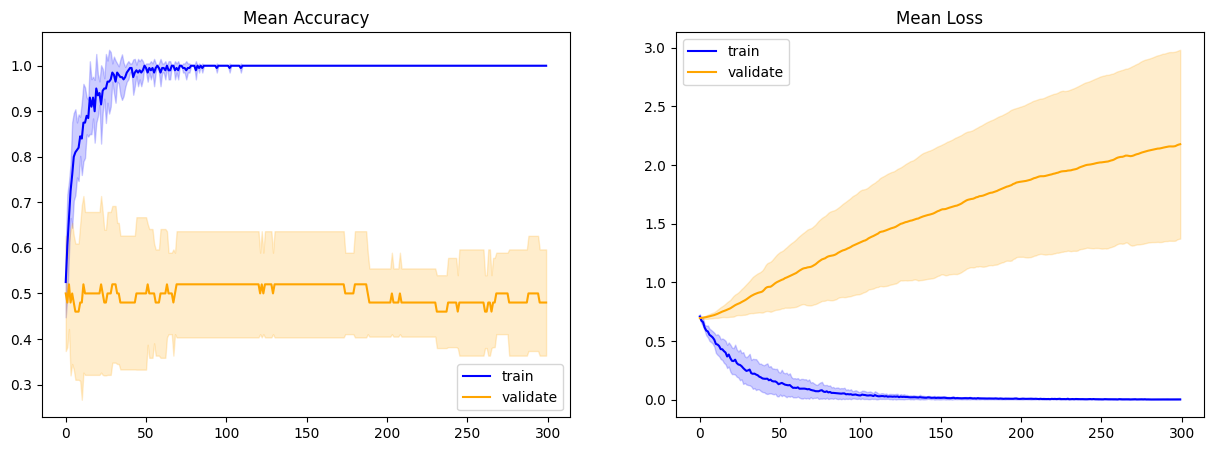

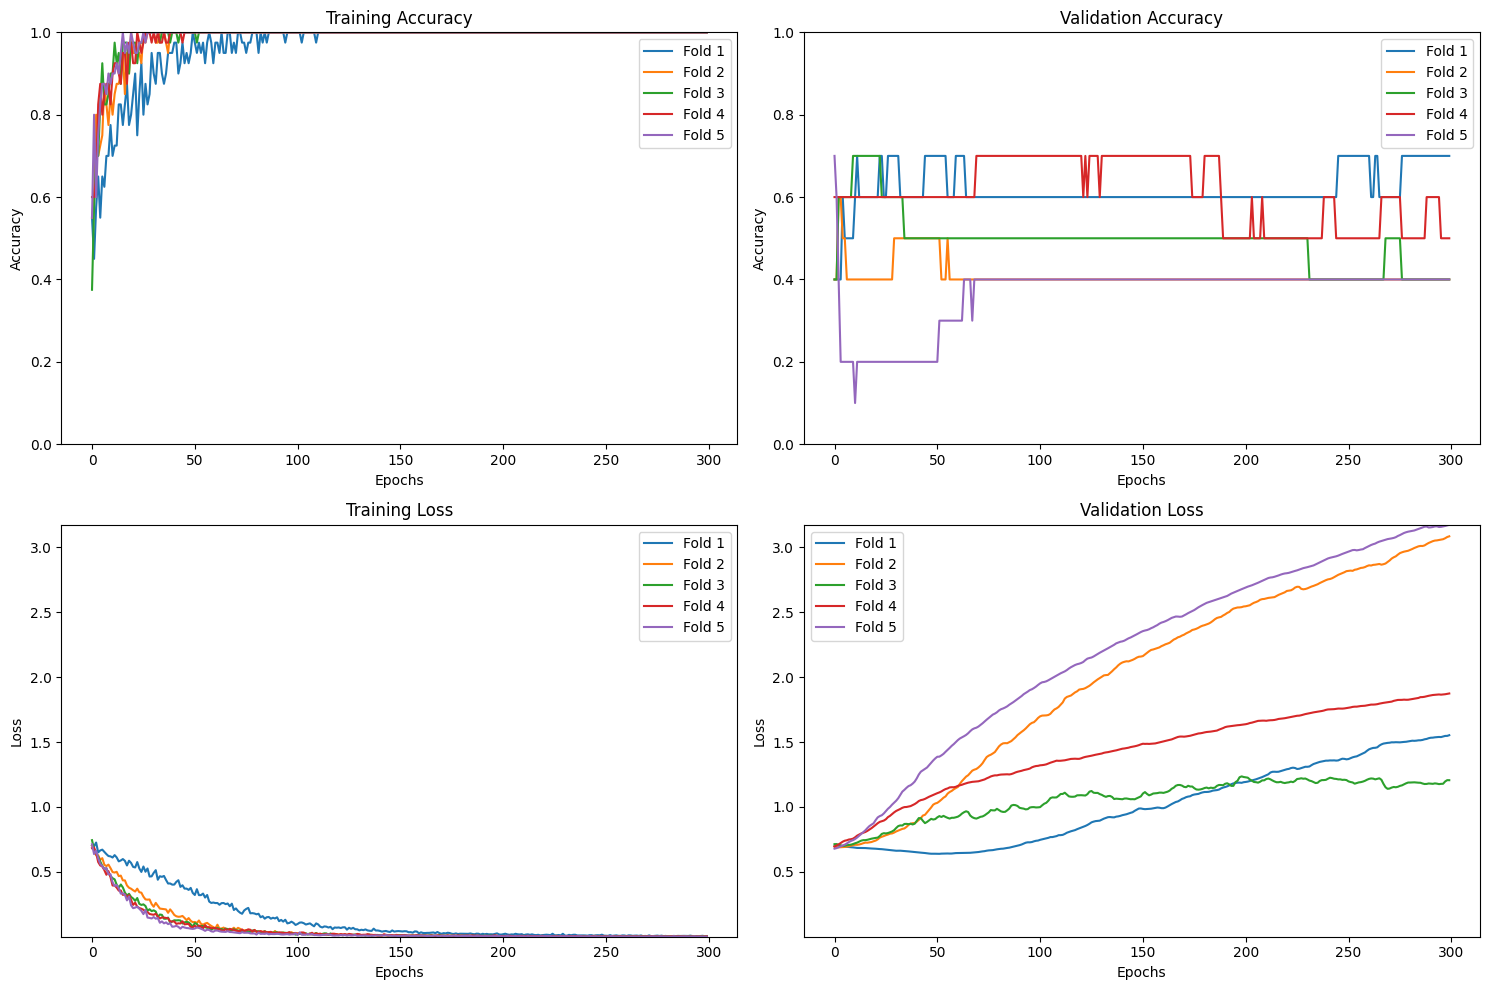

In [8]:
crossvalidate(df_norm, model1, predictors, "class_timepoint", kf)

We can see that model is not suffering from overfitting problem, however the results are bad with accuracy barely exceeding 0.6 where 0.5 is baseline for randomly assigning classes. Confusion Matrix also reveals that model is not far from random choices, this could mean two things:
1. Model is bad 
2. There are no differencecs to be found 

As we checked different models and it is suspected that the change in time is depended on different probiotic supplementation we will not go down this path, second thing we will check in downstream analysys.

### Modeling differences between Classes for both timepoints at the same time

In [13]:
df.head()

,pond,class_timepoint,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Sutterellaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Comamonadaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Rhodocyclaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Sphingobacteriales;f__Lentimicrobiaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfobulbaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Chitinophagales;f__Saprospiraceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae,d__Bacteria;p__Actinobacteriota;c__Thermoleophilia;o__Solirubrobacterales;f__67-14,...,d__Bacteria;p__Desulfobacterota;c__Desulfobacteria;o__Desulfobacterales;f__Desulfobacterales,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Sulfurimonadaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfurivibrionaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;__,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Marinilabiliaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rs-E47_termite_group,d__Bacteria;p__Chloroflexi;c__Dehalococcoidia;o__Dehalococcoidales;f__uncultured,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Barnesiellaceae,d__Bacteria;p__Myxococcota;c__Polyangia;o__Blfdi19;f__Blfdi19
0,Sed_S10,0,111.0,128.0,122.0,101.0,84.0,44.0,42.0,52.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Sed_S10,1,18.0,150.0,10.0,129.0,0.0,0.0,30.0,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Sed_S11,0,81.0,21.0,29.0,90.0,0.0,8.0,10.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Sed_S11,1,3.0,13.0,18.0,3.0,0.0,3.0,18.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Sed_S12,0,171.0,67.0,109.0,76.0,23.0,31.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
model2 = keras.Sequential()



model2.add(keras.layers.Dense(256,input_shape=(len(predictors),),activation='relu'))


#model2.add(keras.layers.Dropout(rate=0.25))
model2.add(keras.layers.Dense(64, activation ='relu'))
#model2.add(keras.layers.Dropout(rate=0.25))
model2.add(keras.layers.Dense(16, activation ='relu'))

model2.add(keras.layers.Dense(5, activation ='softmax'))

loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model2.compile(optimizer = optimizer, loss = loss, metrics=metrics)

training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.1000 - loss: 3.1594
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
predicted classes:       [2 1 1 1 2 2 3 2 2 4]
true validation classes: [2 0 0 0 4 4 1 3 3 0]
mean confidence score: 11.8875, sd confidence score: 15.6837
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2000 - loss: 2.7282
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
predicted classes:       [0 1 4 3 1 1 2 2 2 2]
true validation classes: [4 1 0 4 3 2 2 0 4 3]
mean confidence score: 13.3629, sd confidence score: 17.7448
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5000 - loss: 1.8766
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
predicted classes:       [4 3 3 3 4 1 1 1 0 0]
true validation classes: [1 3 0 1 4 1 1 1 2 2]
mean confidence score: 139.2595, sd confidence score: 390.0334
training for 4 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.1000 - loss: 4.1182
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
pred

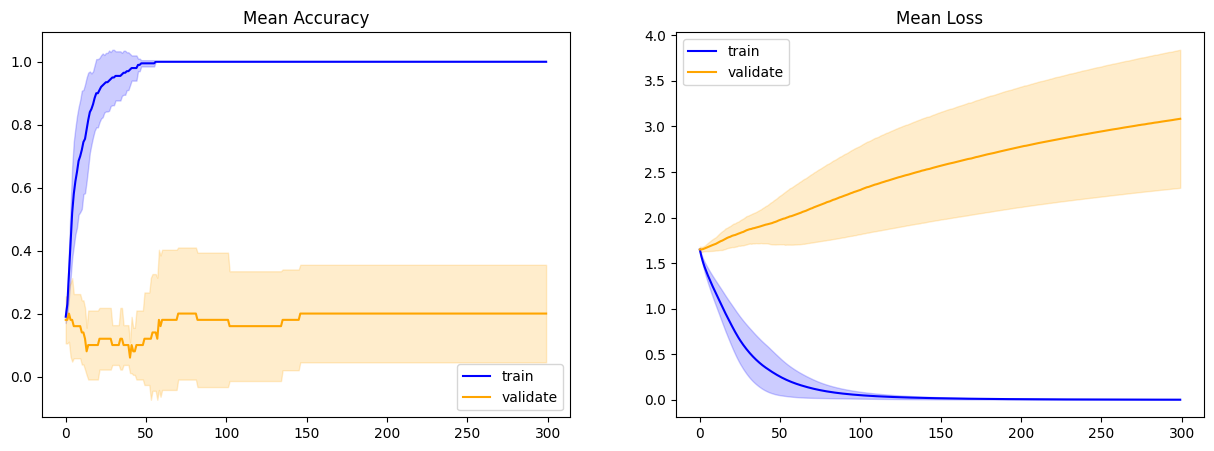

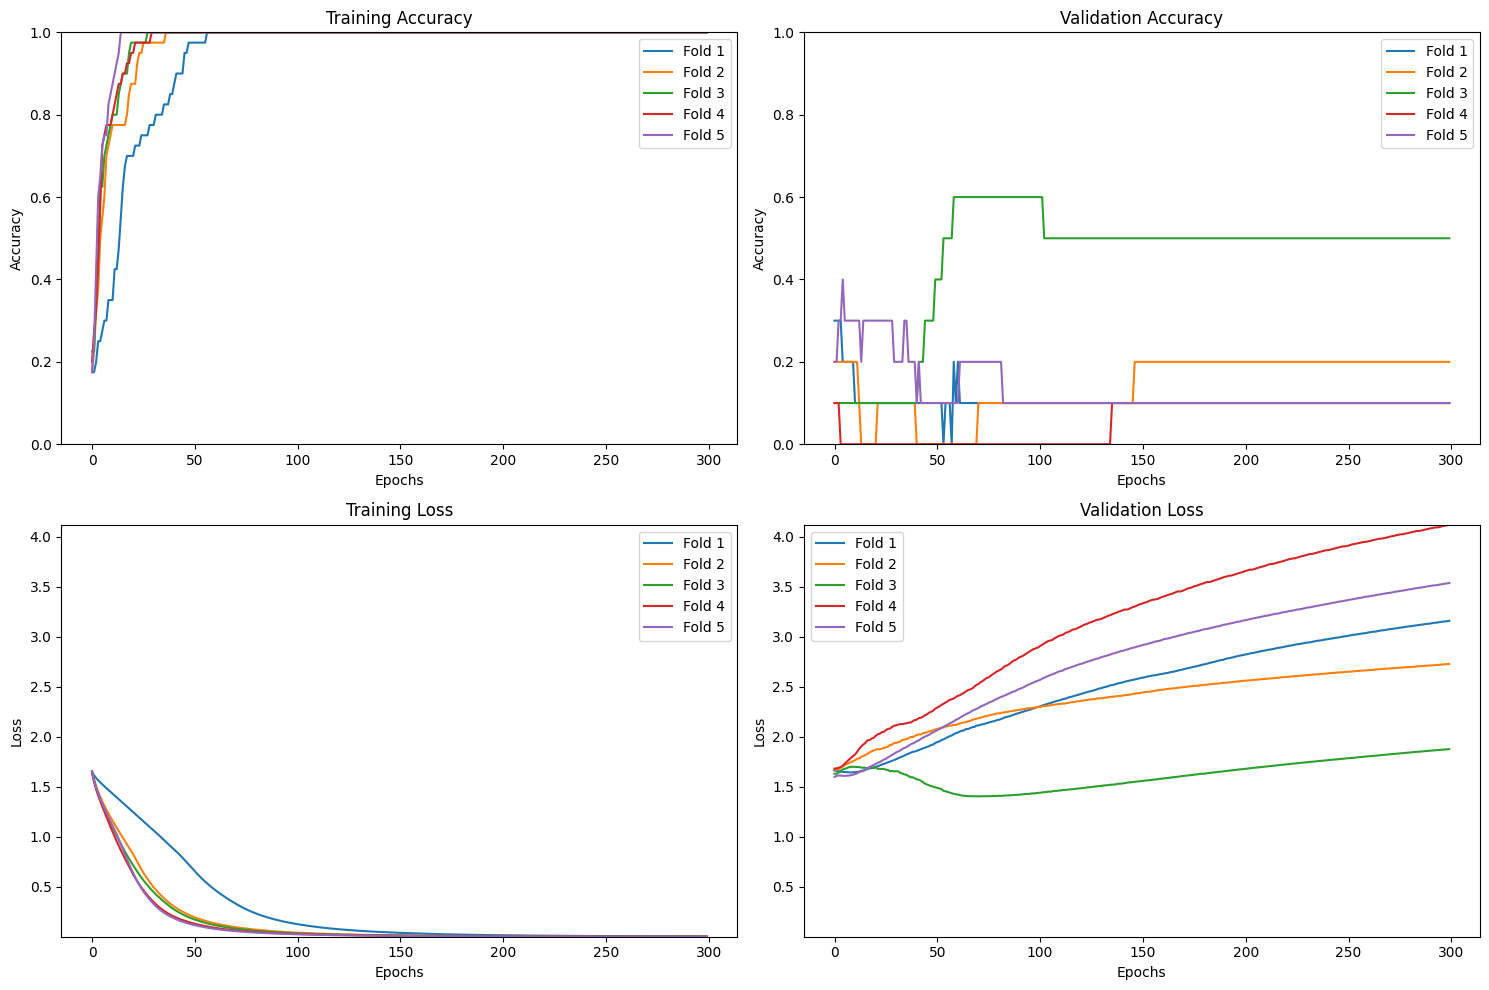

In [15]:
crossvalidate(df_norm, model2, predictors, "class_pond", kf)

Not normalised dataset

training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.1000 - loss: 18.1515
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
predicted classes:       [0 1 2 1 4 2 4 4 2 2]
true validation classes: [2 0 0 0 4 4 1 3 3 0]
mean confidence score: 4445.6731, sd confidence score: 12655.1131
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2000 - loss: 7.1054
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
predicted classes:       [0 1 4 2 1 1 1 1 4 4]
true validation classes: [4 1 0 4 3 2 2 0 4 3]
mean confidence score: 8112.2892, sd confidence score: 19109.0454
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1000 - loss: 12.7429
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
predicted classes:       [4 2 4 0 0 1 4 0 4 0]
true validation classes: [1 3 0 1 4 1 1 1 2 2]
mean confidence score: 1077656.0434, sd confidence score: 3203822.5193
training for 4 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0000e+00 - loss: 8.7808
1/1 ━━━━━━━━━━━━━━━

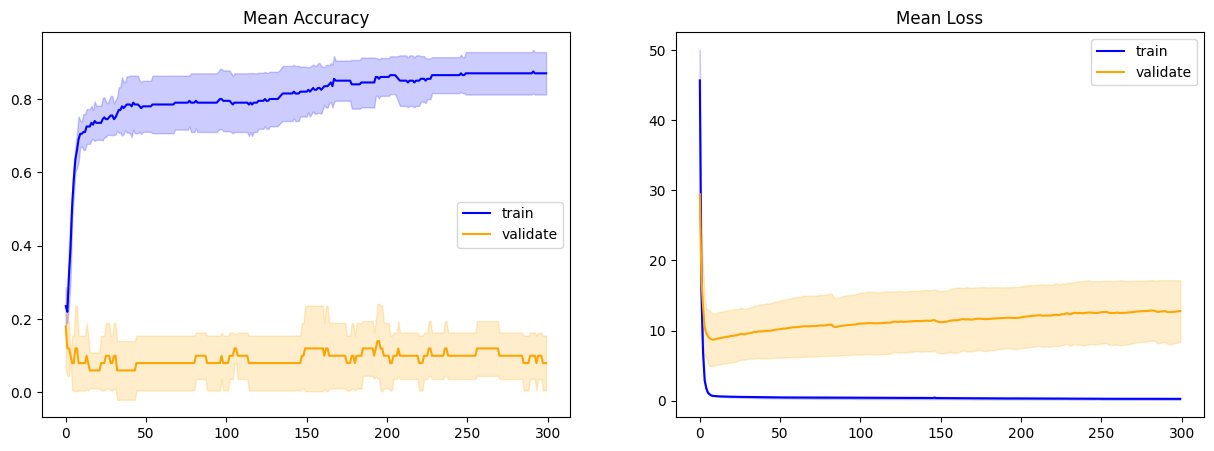

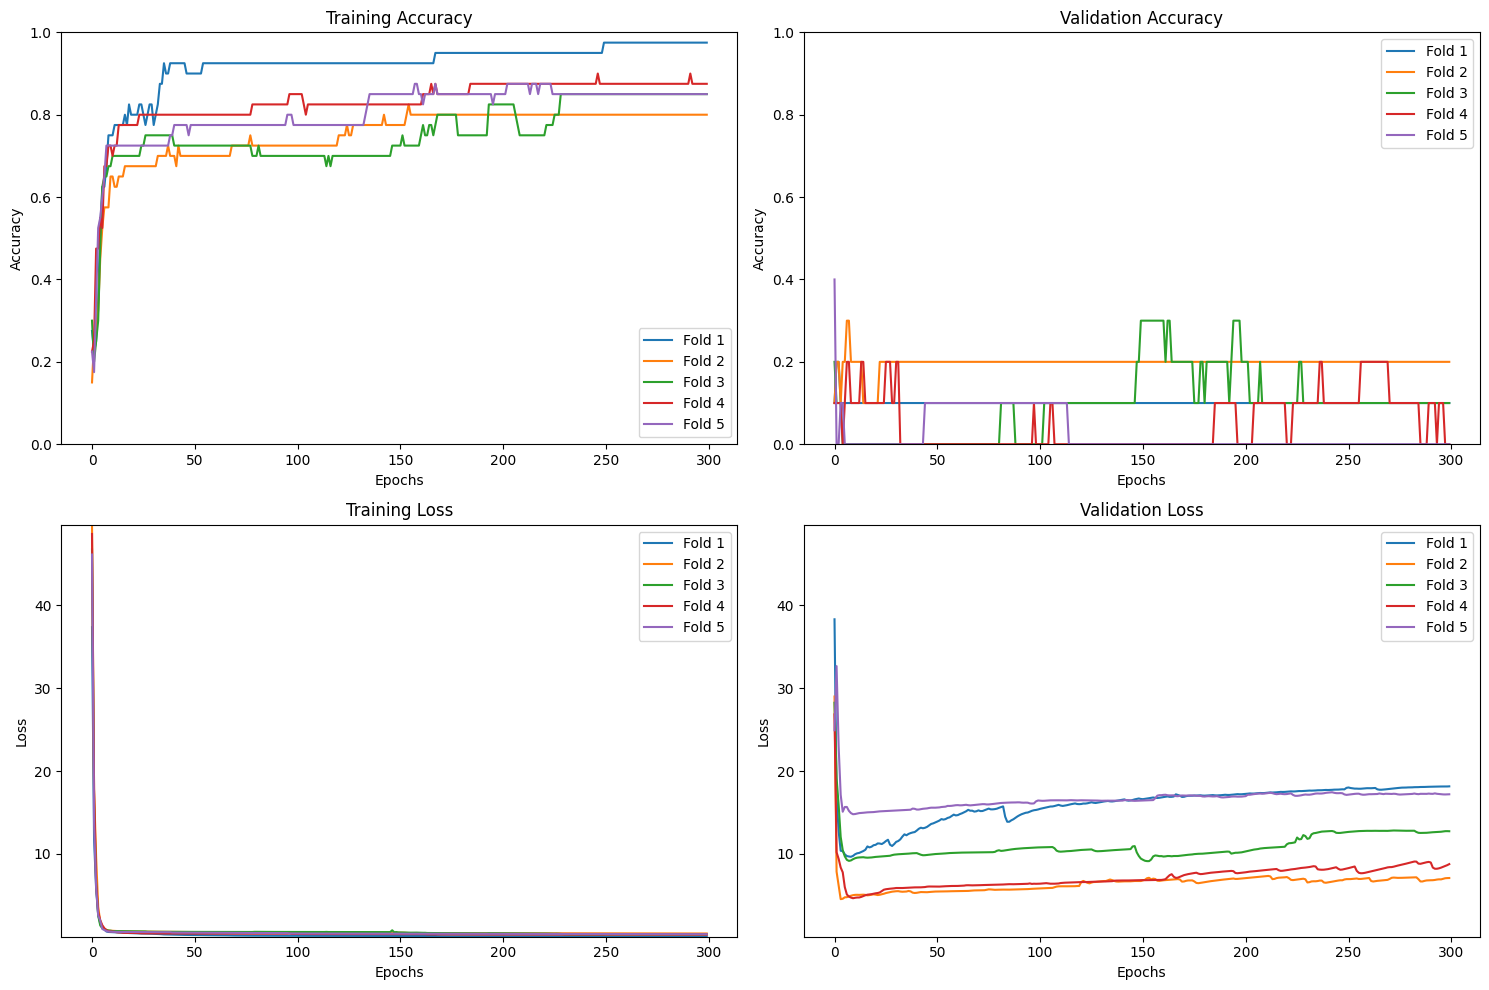

In [28]:
crossvalidate(df, model2, predictors, "class_pond", kf)

We can see here that there is problem with overfitting and becouse that there is not much viable learining happening after around epoch 80+ and once again accuracy is below random threshold of 0.2. The cause of that is probably becouse its hard for model to see differences in class only when timepoint probably plays viable role in change of bacteria abundance. We will now try to classify in only one timepoint for that we will chose second timepoint as that is the one where supplementation could have chance to impact microbiome. Issue with that is we will halve our dataset which is already small (from 50 to 25 samples).

### Modeling class differences in second timepoint

In [16]:
df_second_tp = df_norm[df_norm["class_timepoint"]==1]
print(df_second_tp.shape)
df_second_tp.head()

(25, 230)


,pond,class_timepoint,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Sutterellaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Comamonadaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Rhodocyclaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Sphingobacteriales;f__Lentimicrobiaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfobulbaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Chitinophagales;f__Saprospiraceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae,d__Bacteria;p__Actinobacteriota;c__Thermoleophilia;o__Solirubrobacterales;f__67-14,...,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Sulfurimonadaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfurivibrionaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;__,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Marinilabiliaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rs-E47_termite_group,d__Bacteria;p__Chloroflexi;c__Dehalococcoidia;o__Dehalococcoidales;f__uncultured,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Barnesiellaceae,d__Bacteria;p__Myxococcota;c__Polyangia;o__Blfdi19;f__Blfdi19,class_pond
1,Sed_S10,1,0.048913,0.585938,0.005269,0.758824,0.000000,0.000000,0.265487,0.615385,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,Sed_S11,1,0.008152,0.050781,0.009484,0.017647,0.000000,0.034884,0.159292,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
5,Sed_S12,1,0.127717,0.343750,0.012645,0.247059,0.000000,0.023256,0.000000,0.173077,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
7,Sed_S13,1,0.380435,0.441406,0.197050,0.394118,0.029126,1.000000,0.000000,0.076923,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
9,Sed_S14,1,0.491848,0.859375,0.131191,0.276471,0.223301,0.488372,0.353982,0.076923,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [17]:
model3 = keras.Sequential()



model3.add(keras.layers.Dense(256,input_shape=(len(predictors),),activation='relu'))


model3.add(keras.layers.Dropout(rate=0.25))
model3.add(keras.layers.Dense(64, activation ='relu'))
model3.add(keras.layers.Dropout(rate=0.25))
model3.add(keras.layers.Dense(16, activation ='relu'))

model3.add(keras.layers.Dense(5, activation ='softmax'))

loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model3.compile(optimizer = optimizer, loss = loss, metrics=metrics)

C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.0000e+00 - loss: 4.6888
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
predicted classes:       [1 1 1 3 3]
true validation classes: [3 0 2 0 4]
mean confidence score: 66.6966, sd confidence score: 124.7794
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0000e+00 - loss: 2.9072
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
predicted classes:       [2 0 3 0 4]
true validation classes: [4 1 1 3 2]
mean confidence score: 4.9122, sd confidence score: 4.2863
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2000 - loss: 2.3685
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
predicted classes:       [1 0 0 1 3]
true validation classes: [2 4 3 1 0]
mean confidence score: 2.8946, sd confidence score: 1.9777
training for 4 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.0000e+00 - loss: 5.0306
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
predicted classes:       [4 4 4 2 3]
true validation clas

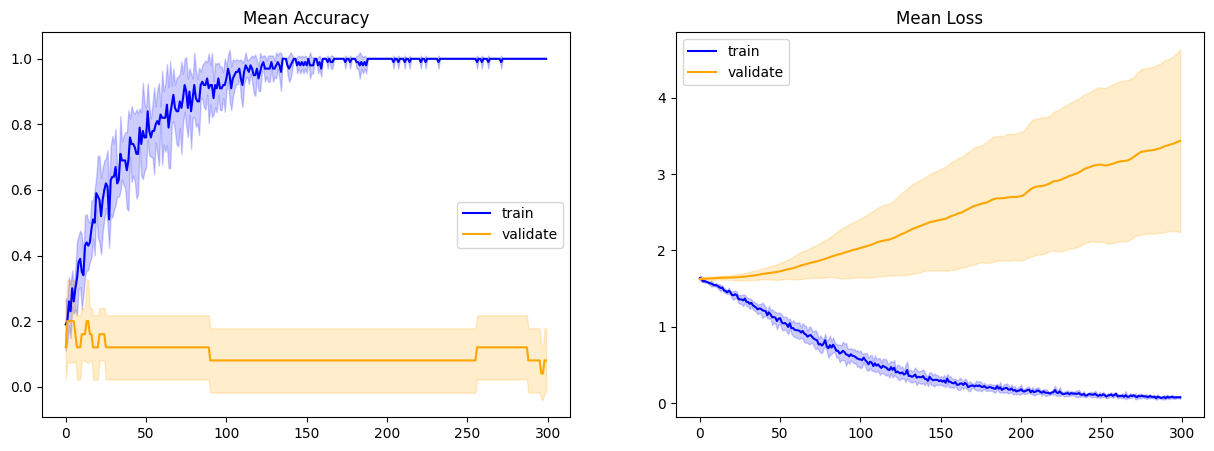

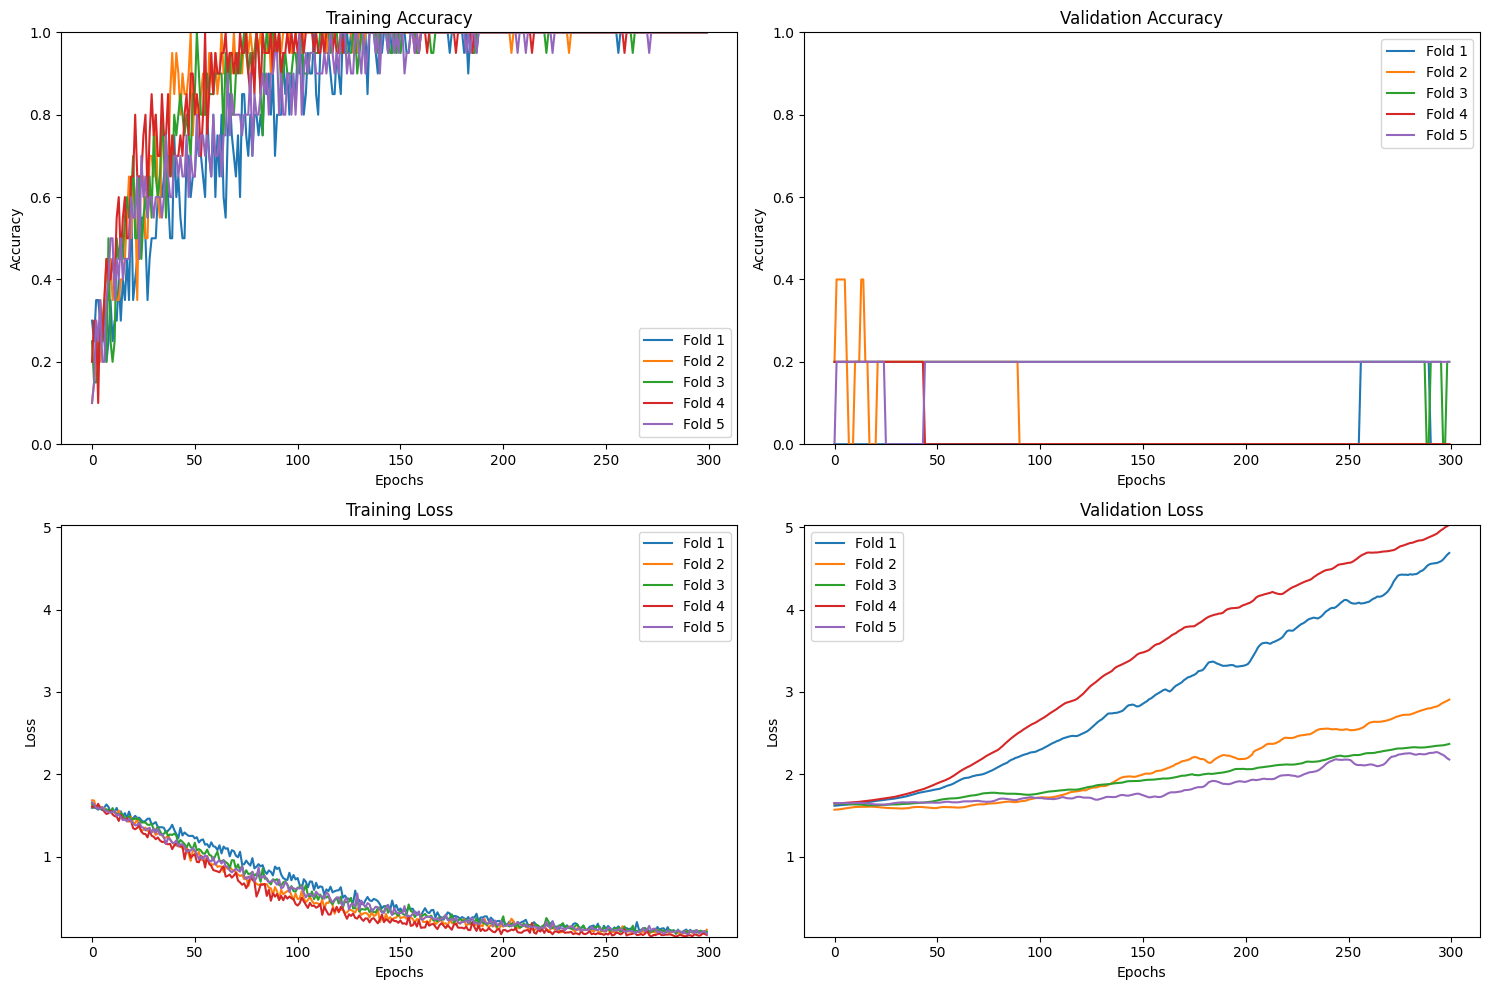

In [18]:
crossvalidate(df_second_tp, model3, predictors, "class_pond", kf)

From those results we can clearly see that its very hard to work with neural networks on such small sample sizes even when we choose to have 20 samples aviable for training the results were bad. We can also check how the model behaves when we split data into 10 classes (timepoint*experimetnal_setup)

### Modeling for Experimental setup and timepoint

In [8]:
df["class_timepointXpond"] = df["class_timepoint"].astype(str) + "_" + df["class_pond"].astype(str)
df_norm["class_timepointXpond"] = df["class_timepoint"].astype(str) + "_" + df["class_pond"].astype(str)

C:\Users\marek\AppData\Local\Temp\ipykernel_23452\3322154788.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_norm["class_timepointXpond"] = df["class_timepoint"].astype(str) + "_" + df["class_pond"].astype(str)


In [10]:
df_norm["class_timepointXpond_encoded"] = LabelEncoder().fit_transform(df_norm["class_timepointXpond"])
df_norm["class_timepointXpond_encoded"] = df_norm["class_timepointXpond_encoded"].astype(int)

C:\Users\marek\AppData\Local\Temp\ipykernel_23452\3234183536.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_norm["class_timepointXpond_encoded"] = LabelEncoder().fit_transform(df_norm["class_timepointXpond"])


In [11]:
model4 = keras.Sequential()



model4.add(keras.layers.Dense(256,input_shape=(len(predictors),),activation='relu'))


model4.add(keras.layers.Dropout(rate=0.25))
model4.add(keras.layers.Dense(64, activation ='relu'))
model4.add(keras.layers.Dropout(rate=0.25))
model4.add(keras.layers.Dense(16, activation ='relu'))

model4.add(keras.layers.Dense(10, activation ='softmax'))

loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model4.compile(optimizer = optimizer, loss = loss, metrics=metrics)

C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
crossvalidate(df_norm, model4, predictors, "class_timepointXpond_encoded", kf)

training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.1000 - loss: 3.6771
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
predicted classes:       [7 1 9 4 7 5 6 7 7 9]
true validation classes: [2 0 5 5 4 9 6 3 8 0]
mean confidence score: 9.3597, sd confidence score: 8.4681
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.0000e+00 - loss: 4.7797
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
predicted classes:       [4 4 4 0 1 6 5 5 4 4]
true validation classes: [9 1 5 9 8 7 2 0 9 3]
mean confidence score: 14.5969, sd confidence score: 19.4072
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.0000e+00 - loss: 3.6004
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
predicted classes:       [4 0 3 5 4 3 4 7 2 3]
true validation classes: [6 3 0 6 9 1 6 1 7 7]
mean confidence score: 7.2788, sd confidence score: 8.4178
training for 4 subset


InvalidArgumentError: Graph execution error:

Detected at node compile_loss/categorical_crossentropy/softmax_cross_entropy_with_logits defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.2032.0_x64__qbz5n2kfra8p0\Lib\asyncio\base_events.py", line 641, in run_forever

  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.2032.0_x64__qbz5n2kfra8p0\Lib\asyncio\base_events.py", line 1986, in _run_once

  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.2032.0_x64__qbz5n2kfra8p0\Lib\asyncio\events.py", line 88, in _run

  File "C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\ipykernel\ipkernel.py", line 362, in execute_request

  File "C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\ipykernel\ipkernel.py", line 449, in do_execute

  File "C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell

  File "C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell

  File "C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async

  File "C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes

  File "C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code

  File "C:\Users\marek\AppData\Local\Temp\ipykernel_23452\620837427.py", line 1, in <module>

  File "c:\Users\marek\My Drive\Ryby\Ryby\sed_based\functions.py", line 72, in crossvalidate

  File "C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\backend\tensorflow\trainer.py", line 339, in fit

  File "C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\backend\tensorflow\trainer.py", line 425, in evaluate

  File "C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\backend\tensorflow\trainer.py", line 161, in one_step_on_iterator

  File "C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\backend\tensorflow\trainer.py", line 150, in one_step_on_data

  File "C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\backend\tensorflow\trainer.py", line 81, in test_step

  File "C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\trainer.py", line 316, in compute_loss

  File "C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\compile_utils.py", line 609, in __call__

  File "C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\compile_utils.py", line 645, in call

  File "C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\losses\loss.py", line 43, in __call__

  File "C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\losses\losses.py", line 22, in call

  File "C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\losses\losses.py", line 1576, in categorical_crossentropy

  File "C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\ops\nn.py", line 1482, in categorical_crossentropy

  File "C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\backend\tensorflow\nn.py", line 564, in categorical_crossentropy

logits and labels must be broadcastable: logits_size=[5,10] labels_size=[5,9]
	 [[{{node compile_loss/categorical_crossentropy/softmax_cross_entropy_with_logits}}]] [Op:__inference_one_step_on_iterator_41213]

Although we dont see signs of overfitting accuracy is lackluster either, close to random. We will now reuse 2 class classification approach from gut dataset. This time we will use enviromental.
supplementation as class. This will be in next notebook Sediment_2.ipynb